# Load Prepared Spectra from preprocess.ipynb

In [1]:
import numpy as np
import pandas as pd
import pickle
save_ap_name ='./data/mgaint_ap_train.pickcle'

with open(save_ap_name, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    asp_dict = pickle.load(f)

params_ap = np.c_[asp_dict['new_df']['TEFF'], asp_dict['new_df']['FE_H'], 
                  asp_dict['new_df']['LOGG'], asp_dict['new_df']['ALPHA_M']
                 ]

print(params_ap.shape)

(2877, 4)


In [2]:
asp_dict['new_df'].columns

Index(['obsid', 'ra_epoch2000', 'dec_epoch2000', 'snri', 'APSTAR_ID', 'J',
       'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'RA', 'DEC', 'TEFF', 'TEFF_ERR',
       'LOGG', 'LOGG_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'X_H', 'X_H_ERR', 'FE_H',
       'FE_H_ERR'],
      dtype='object')

In [4]:
print(
    asp_dict['new_df']['TEFF'].min(), asp_dict['new_df']['TEFF'].max(), 
    asp_dict['new_df']['TEFF_ERR'].min(), asp_dict['new_df']['TEFF_ERR'].max(), 
    asp_dict['new_df']['FE_H'].min(), asp_dict['new_df']['FE_H'].max(), 
    asp_dict['new_df']['FE_H_ERR'].min(), asp_dict['new_df']['FE_H_ERR'].max(),
    asp_dict['new_df']['LOGG_ERR'].min(), asp_dict['new_df']['LOGG_ERR'].median(),
)

3404.1348 4262.2896 55.533203 94.938774 -1.4841615 0.63558847 0.005801915699999999 0.024019232 0.04090392 0.053428132


# SLAM Module

In [6]:
from slam import Slam

s = Slam(asp_dict['wave'], # wavelength grid
         tr_flux=np.array(asp_dict['flux']), # training flux
         tr_ivar=np.array(asp_dict['invar']), # training ivar
         tr_labels=params_ap, # training labels
         scale=True, # if True, scale flux and labels. default is True
         robust=False, # if True, use robust scaling. default is True --> this is to tackle the cosmic rays
         mask_conv=(1, 2), # lower and upper limits of the kernel used in convolution
         flux_bounds=(0.001, 100.0), # flux bounds. 
         ivar_eps=0, # slam will eliminate the pixels whose ivar<ivar_eps
        )

s.train_pixels(
    profile=None, targets='all', temp_dir=None, sample_weight_scheme='bool', # usually you can leave these unchanged
    model='nn', # model type: svr/nn
    method='simple', # simple/grid. if simple, specify hyperparameter values; if grid, specify the grid
    # param_grid=pgrid, # the grid
    cv=3, # cv fold
    scoring='neg_mean_squared_error', 
    n_jobs=20, verbose=5) # parallel

@Slam.heal_the_world: IVAR of 2 spectra need to be reset
(21, 87), (1228, 2), 

@Slam.heal_the_world: FLUX of 0 spectra need to be reset


@SLAM: updating data dimensions!
----------------------------------
n_obs: 0 --> 2877
n_pix: 0 --> 1596
n_dim: 0 --> 4
----------------------------------


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:   15.4s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:   43.1s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  2.3min
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:  3.3min
[Parallel(n_jobs=20)]: Done 842 tasks      | elapsed:  4.6min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:  6.2min
[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed:  8.0min


         C  gamma  epsilon
count  0.0    0.0      0.0
mean   NaN    NaN      NaN
std    NaN    NaN      NaN
min    NaN    NaN      NaN
25%    NaN    NaN      NaN
50%    NaN    NaN      NaN
75%    NaN    NaN      NaN
max    NaN    NaN      NaN


[Parallel(n_jobs=20)]: Done 1596 out of 1596 | elapsed:  9.0min finished


@Slam.heal_the_world: IVAR of 0 spectra need to be reset


@Slam.heal_the_world: FLUX of 0 spectra need to be reset

@Slam.heal_the_world: IVAR of 0 spectra need to be reset


@Slam.heal_the_world: FLUX of 0 spectra need to be reset

@SLAM: NMSE is not available and will be calculated now!
@SLAM: The spectra with fewest pixels unmasked is [1072/1596]
@SLAM3: nfev=25, status=2, pstd=[3.15916394 0.01954229 0.03219366 0.00562541]
@SLAM3: nfev=24, status=2, pstd=[9.36088149 0.03151359 0.06097419 0.0110408 ]
@SLAM3: nfev=20, status=2, pstd=[2.0900624  0.02413819 0.03302363 0.00528867]
@SLAM3: nfev=37, status=2, pstd=[3.50470899 0.02059171 0.02950528 0.00945634]
@SLAM3: nfev=21, status=2, pstd=[4.03918389 0.02815628 0.04128843 0.00779006]
@SLAM3: nfev=22, status=2, pstd=[10.38521246  0.02599991  0.05268262  0.01214551]
@SLAM3: nfev=24, status=2, pstd=[5.40005057 0.02053698 0.0290039  0.00818465]
@SLAM3: nfev=23, status=2, pstd=[2.44481797 0.0141539  0.02354662 0.00490346]
@SLAM3: nfev=26, st

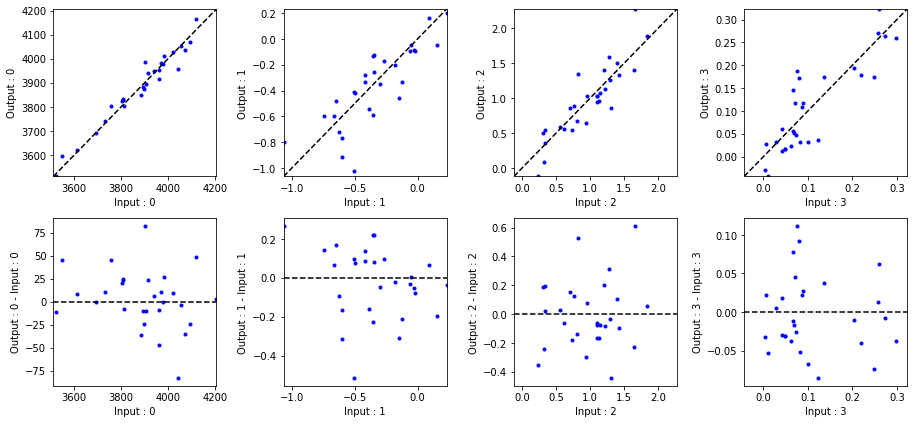

In [7]:
Xinit = s.predict_labels_quick(s.tr_flux, s.tr_ivar)
Rpred = s.predict_labels_multi(Xinit[::100], s.tr_flux[::100], s.tr_ivar[::100])
Xpred = np.array([_["x"] for _ in Rpred])

# Save the slam model
s.save_dump('./model/ASPCAP_DR16_mgiant.dump')

In [ ]:
# %%
from slam.diagnostic import compare_labels
fig = compare_labels(s.tr_labels[::100], Xpred, 
                     labelname1="APOGEE DR16", labelname2="SLAM")

# Predict labels of new spectra using trained-SLAM model

In [12]:
spec_name ='./data/mgiant_spec_dict.pickcle'

with open(spec_name, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    lm_spec = pickle.load(f)

In [15]:
Xinit = s.predict_labels_quick(lm_spec['flux'], lm_spec['invar'])

np.savez("./data/mgiant_ap_init.npz", Xinit)
Rpred = s.predict_labels_ipc(Xinit, lm_spec['flux'], lm_spec['invar'], 
                             use_old=False)


Xpred = np.array([_["x"] for _ in Rpred])
Xpred_err = np.array([np.diag(_["pcov"]) for _ in Rpred])
Xpred_status = np.array([_["status"] for _ in Rpred])

/home/jdli/anaconda3/lib/python3.7/site-packages/slam/slam3.py:1694: RuntimeWarning: invalid value encountered in greater
  ind_flux_in_bounds = (flux > flux_bounds[0]) & (flux < flux_bounds[1])
/home/jdli/anaconda3/lib/python3.7/site-packages/slam/slam3.py:1694: RuntimeWarning: invalid value encountered in less
  ind_flux_in_bounds = (flux > flux_bounds[0]) & (flux < flux_bounds[1])
/home/jdli/anaconda3/lib/python3.7/site-packages/slam/slam3.py:1696: RuntimeWarning: invalid value encountered in greater
  ind_ivar_valid = ivar > ivar_eps


@Slam.heal_the_world: IVAR of 518 spectra need to be reset
(0, 10), (4, 1), (32, 2), (43, 66), (61, 62), (62, 511), (63, 96), (68, 1), (86, 3), (88, 2), (119, 11), (144, 9), (190, 2), (197, 38), (199, 27), (204, 21), (212, 260), (213, 3), (218, 618), (248, 2), (312, 1), (317, 324), (318, 33), (320, 249), (321, 138), (322, 73), (325, 3), (331, 40), (332, 468), (336, 6), (340, 329), (341, 5), (342, 213), (345, 325), (357, 91), (363, 102), (372, 1), (416, 96), (438, 87), (440, 451), (453, 70), (464, 136), (532, 91), (599, 1), (612, 1), (646, 1), (647, 1), (649, 1), (721, 5), (757, 1), (796, 3), (958, 2), (1098, 1), (1221, 2), (1298, 28), (1309, 39), (1321, 8), (1351, 1), (1356, 5), (1416, 1), (1447, 2), (1623, 55), (1628, 2), (1671, 63), (1716, 1), (1866, 2), (1914, 3), (1918, 2), (1935, 2), (2036, 1), (2047, 10), (2121, 1), (2291, 2), (2294, 18), (2302, 29), (2347, 36), (2352, 4), (2361, 1), (2382, 1), (2393, 3), (2401, 27), (2423, 1), (2662, 1), (2684, 1), (2732, 2), (2881, 1596), (2896

In [30]:
result_df = pd.DataFrame({'obsid':lm_spec['obsid'], 
                          'Teff_slam':Xpred[:,0], 'Teff_slam_err':Xpred_err[:,0], 
                          'feh_slam':Xpred[:,1], 'feh_slam_err':Xpred_err[:,1], 
                          'logg_slam':Xpred[:,2], 'logg_slam_err':Xpred_err[:,2], 
                          'alpha_m_slam':Xpred[:,3], 'alpha_m_slam_err':Xpred_err[:,3], 
                          'slam_status':Xpred_status
    
})
result_df.to_csv('./data/mgaint_SlamParams_v0.csv', index=False)